This tutorial reproduces the results of Tutorial 11 on spinw.org. It is on the spin wave spectrum of La2Cu04. The exchange values were taken from "R. Coldea, Phys. Rev. Lett. 86, 5377 (2001)".

Get Packages

In [15]:
using Sunny, GLMakie, CairoMakie

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. Space group is I4/mmm or 139. Size of supercell is (2,2,1).

In [16]:
a=3.810
b=3.810
c=13.20
latvecs = lattice_vectors(a, b, c, 90, 90, 90)
positions=[[1, 0, 0]]
Cu = Crystal(latvecs,positions,139)
view_crystal(Cu)
print_symmetry_table(Cu,8)
sys=System(Cu, (2,2,1),[SpinInfo(1,S=1/2,g=2)], :dipole, seed=0)

Atom 1
Position [0, 0, 0], multiplicity 2
Allowed g-tensor: [A 0 0
                   0 A 0
                   0 0 B]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,0] + c₃*𝒪[4,4] +
    c₄*𝒪[6,0] + c₅*𝒪[6,4]

Bond(1, 1, [1, 0, 0])
Distance 3.81, coordination 4
Connects [0, 0, 0] to [1, 0, 0]
Allowed exchange matrix: [A 0 0
                          0 B 0
                          0 0 C]

Bond(1, 1, [1, 1, 0])
Distance 5.3881536726415, coordination 4
Connects [0, 0, 0] to [1, 1, 0]
Allowed exchange matrix: [A C 0
                          C A 0
                          0 0 B]

Bond(1, 2, [0, 0, 0])
Distance 7.1286779980583, coordination 8
Connects [0, 0, 0] to [1/2, 1/2, 1/2]
Allowed exchange matrix: [A D C
                          D A C
                          C C B]

Bond(1, 1, [2, 0, 0])
Distance 7.62, coordination 4
Connects [0, 0, 0] to [2, 0, 0]
Allowed exchange matrix: [A 0 0
                          0 B 0
                          0 0 C]



System [Dipole mode]
Lattice (2×2×1)×2
Energy per site 0


Set up the exchanges and the Hamiltonian. THe exchanges upto third nearest neighbour. Randomize the spins and then minimize the energy. Here the exchanges have been doubled because in the original paper, the Hamiltonian has double counting of bonds. 

In [17]:
J1=59.65*2 ##(J-Jc/2)/2
J2=-3.75*2##(Jp-Jc/4)/2
J3=1*2 ##Jpp/2
set_exchange!(sys,J1,Bond(1, 1, [1, 0, 0]))
set_exchange!(sys,J1,Bond(1, 1, [0, 1, 0]))
set_exchange!(sys,J2,Bond(1, 1, [1, 1, 0]))
set_exchange!(sys,J2,Bond(1, 1, [-1, 1, 0]))
set_exchange!(sys,J3,Bond(1, 1, [2, 0, 0]))
set_exchange!(sys,J3,Bond(1, 1, [0, 2, 0]))
randomize_spins!(sys)
minimize_energy!(sys;maxiters=2000)
plot_spins(sys)
energy(sys)

┌ Info: Overriding coupling for Bond(1, 1, [0, 1, 0]).
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/System/Interactions.jl:14
┌ Info: Overriding coupling for Bond(1, 1, [-1, 1, 0]).
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/System/Interactions.jl:14
┌ Info: Overriding coupling for Bond(1, 1, [0, 2, 0]).
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/System/Interactions.jl:14


-499.20000000000005

Create the LSWT object and set up a path. Obtain the dispersion and intensity bands.

In [18]:
q_points=[[3/4,1/4,0],[1/2, 1/2, 0],[1/2, 0, 0],[3/4, 1/4, 0],[1,0,0],[1/2 0 0]]
density = 50
path, xticks = reciprocal_space_path(Cu, q_points, density);
swt=SpinWaveTheory(sys)
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion, convulated spectra and spin-spin correlation. Note that the energies and dispersion values have been scaled by a factor of 1.18 as done in the tutorial on spinw.org.

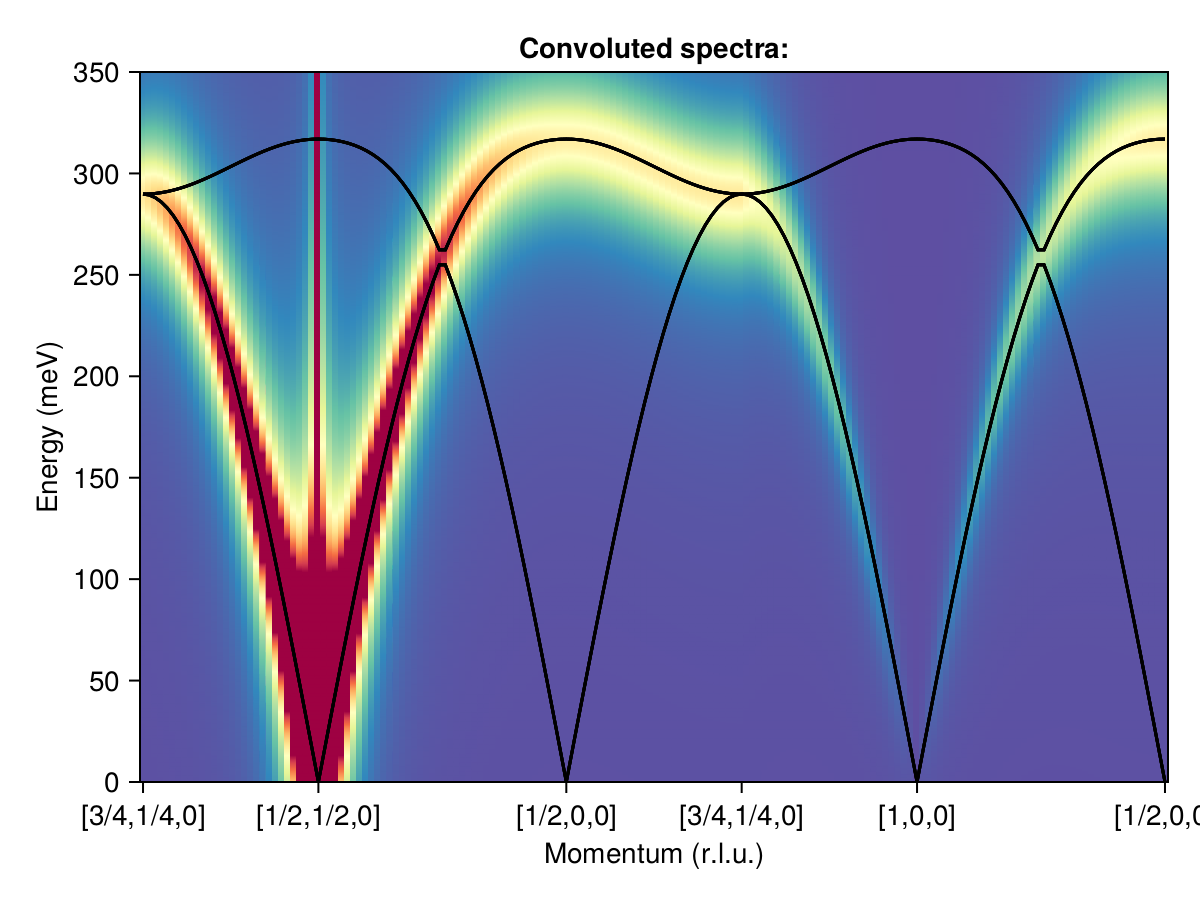

In [19]:
CairoMakie.activate!()
γ =20
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.02:350) 
is = intensities_broadened(swt, path, energies, broadened_formula);
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Convoluted spectra:",xticks)
ylims!(ax, 0.0, 350.0)
pl=heatmap!(ax, 1:size(is, 1), energies*1.18, is,colorrange=(0,0.01))
pl.colormap = Reverse(:Spectral)
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]*1.18; color="black")
end
fig

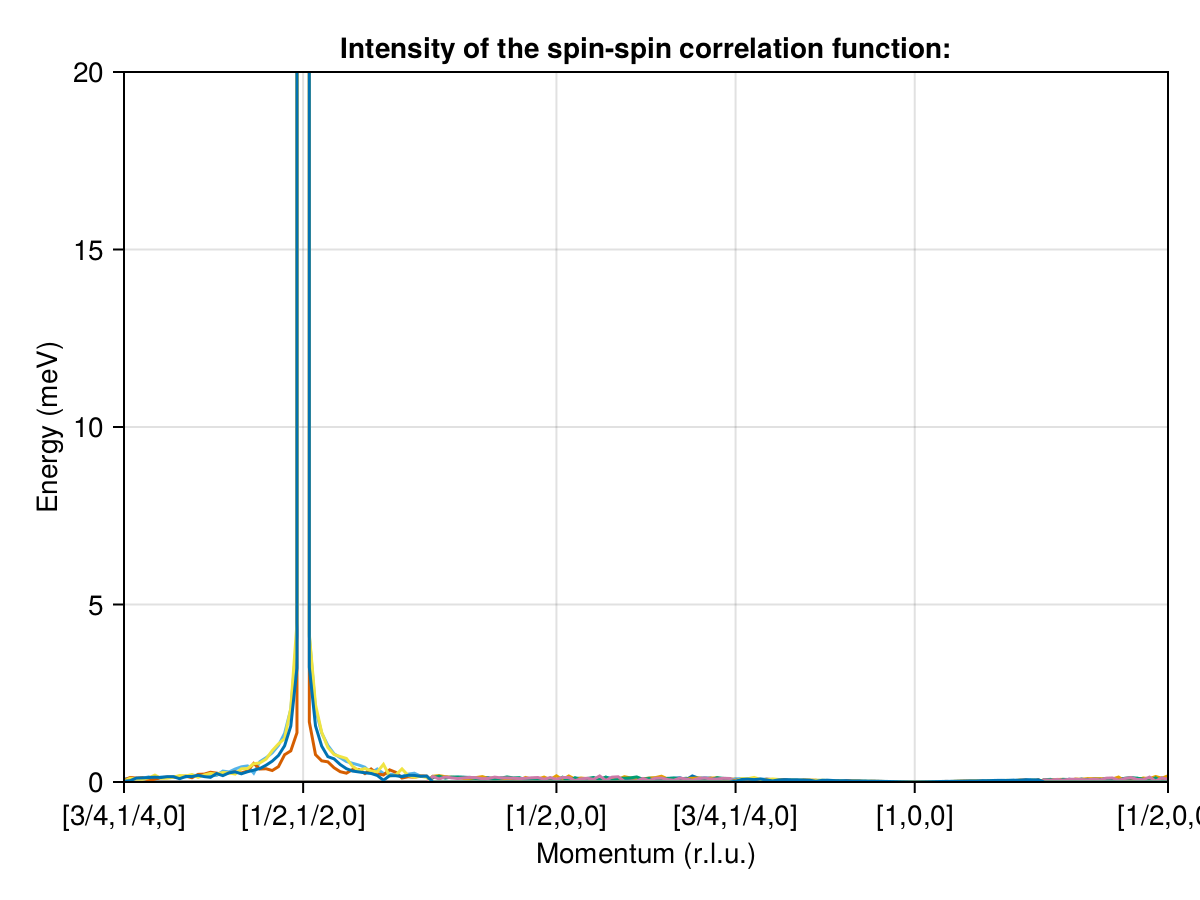

In [20]:
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Intensity of the spin-spin correlation function:", xticks)
ylims!(ax, 0.0, 20)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(intensity[:,i]), intensity[:,i]; colorrange)
end
fig